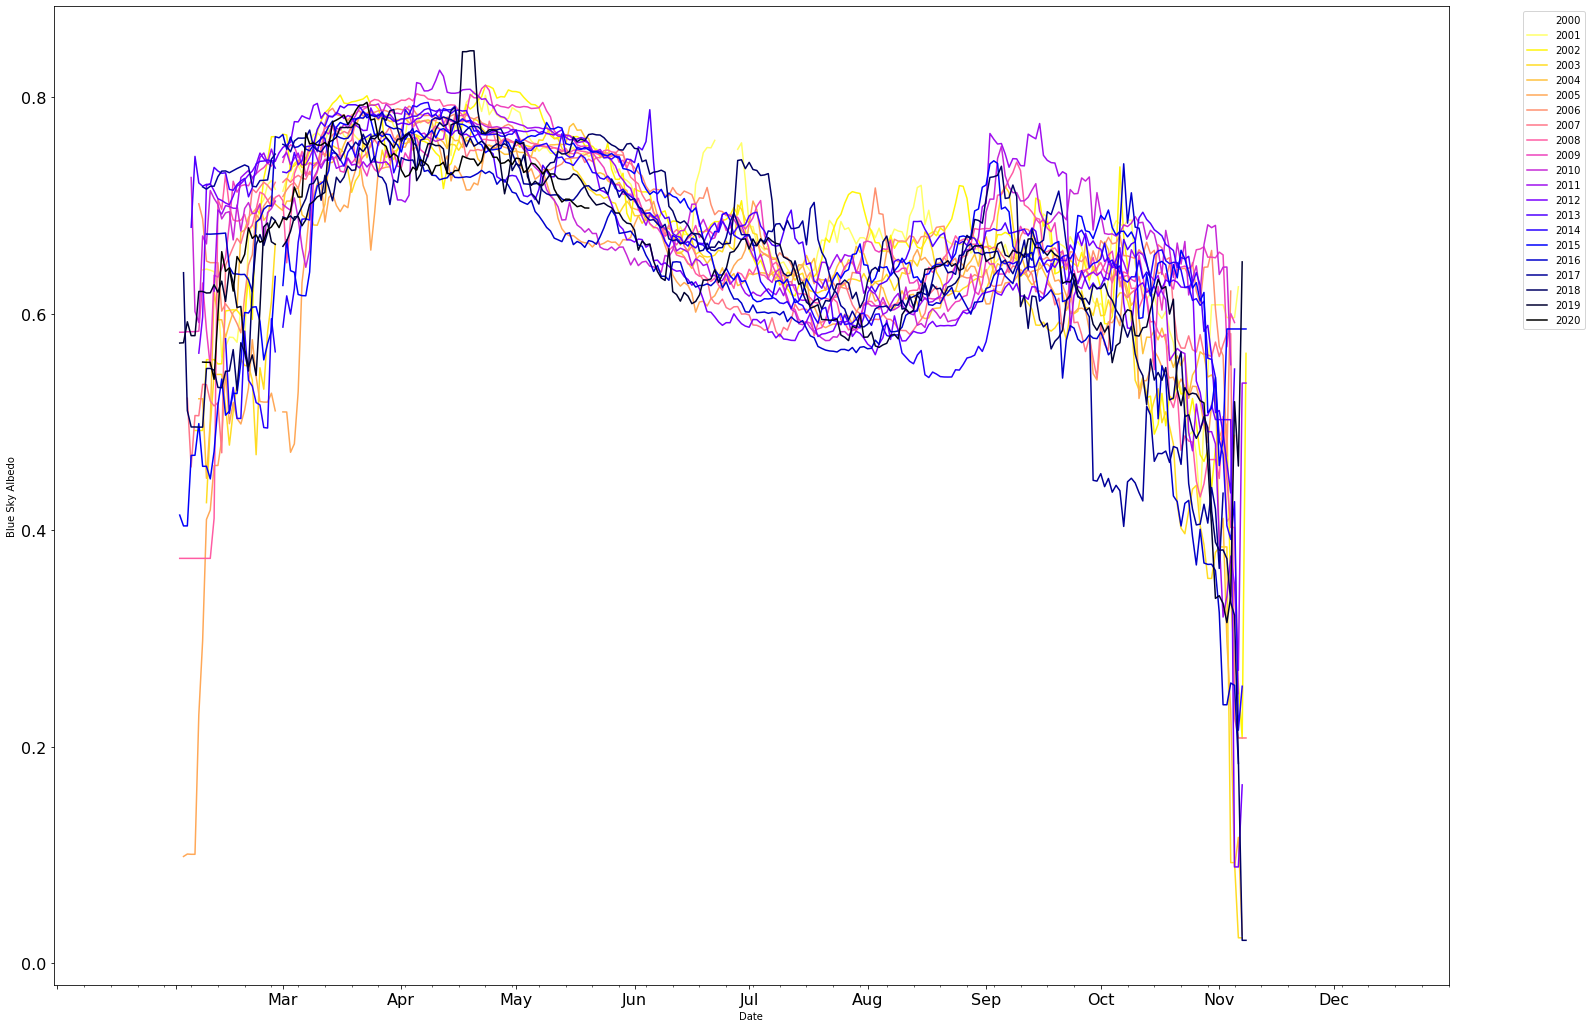

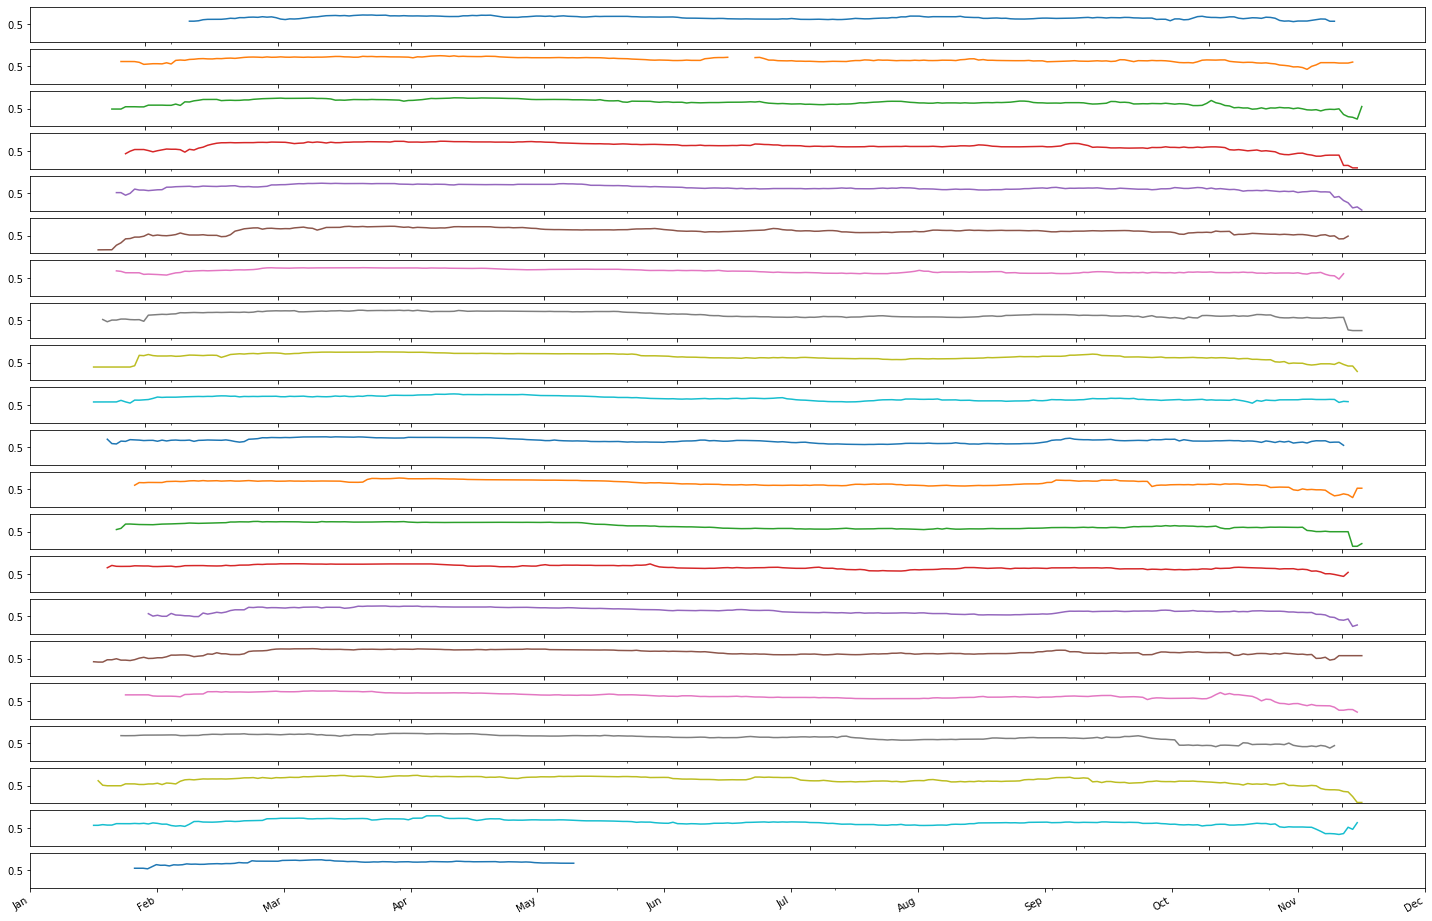

In [138]:
# This makes a plot where all years are stacked up on top of each other, with a color ramp to generally
# tell them apart
import pandas as pd
import datetime as dt
import numpy as np
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)
import matplotlib.dates as mdates
import matplotlib.cm as cm
import seaborn as sns
from pandas import read_csv
from pandas import DataFrame
from pandas import Grouper
from matplotlib import pyplot
import matplotlib.pyplot as plt

workspace='/home/arthur/Dropbox/projects/greenland/aoi_albedo_time_series/'
csv_name=workspace + 'helheim-region-100-pts-MCD43A3-006-results.csv'

# Define the fields of interest so we can ignore the rest
fields = ['Date','MCD43A3_006_Albedo_WSA_shortwave', 'MCD43A3_006_BRDF_Albedo_Band_Mandatory_Quality_shortwave']

# Import raw APPEARS output
ts_df = pd.read_csv(csv_name, usecols=fields, parse_dates=[0], index_col=0)

# Add missing dates to beginning of modis time series
start_date = dt.datetime(2000, 1, 1)
end_date = dt.datetime(2000, 2, 23)
daterange = pd.date_range(start_date, end_date)
empty_wsa = np.full([54,], 32767, dtype=float)
empty_qa = np.full([54,], 255, dtype=int)

pad_df = pd.DataFrame({'Date': daterange, 'MCD43A3_006_Albedo_WSA_shortwave': empty_wsa,
                       'MCD43A3_006_BRDF_Albedo_Band_Mandatory_Quality_shortwave': empty_qa})
pad_df.set_index('Date', inplace=True)

# Add to beginninf of data series
ts_df = pd.concat([pad_df, ts_df])

# Mask out fill values (and could optionally also mask out mag inversions by adding another condition == 1
ts_df['MCD43A3_006_Albedo_WSA_shortwave'].mask(ts_df['MCD43A3_006_BRDF_Albedo_Band_Mandatory_Quality_shortwave'] == 255,
                                               np.NaN, inplace=True)
ts_df['SW_WSA'] = ts_df['MCD43A3_006_Albedo_WSA_shortwave']
del ts_df['MCD43A3_006_BRDF_Albedo_Band_Mandatory_Quality_shortwave']
del ts_df['MCD43A3_006_Albedo_WSA_shortwave']
ts_df = ts_df.groupby(['Date']).mean()

# Plot 2019 (and 2020?) separately, on top of all other years, since it is of interest
ts_df_2017 = ts_df.loc['2017-01-01':'2017-12-31'].copy()
ts_df_2019 = ts_df.loc['2019-01-01':'2019-12-31'].copy()
ts_df_2020 = ts_df.loc['2020-01-01':'2020-12-31'].copy()

# These set the indices for the output in such a way that they can be plotted on top of each other year-wise
# I may just delete these if I find a good enough colormap
idx = pd.MultiIndex.from_arrays([
        pd.to_datetime(ts_df.index.strftime('2012-%m-%d')),
        ts_df.index.year
    ])

idx_2017 = pd.MultiIndex.from_arrays([
        pd.to_datetime(ts_df_2017.index.strftime('2012-%m-%d')),
        ts_df_2017.index.year
    ])

idx_2019 = pd.MultiIndex.from_arrays([
        pd.to_datetime(ts_df_2019.index.strftime('2012-%m-%d')),
        ts_df_2019.index.year
    ])

idx_2020 = pd.MultiIndex.from_arrays([
        pd.to_datetime(ts_df_2020.index.strftime('2012-%m-%d')),
        ts_df_2020.index.year
    ])

#colors = cm.Purples(np.linspace(0,1,21))
colors = cm.gnuplot2_r(np.linspace(0,1,21))

#ax = ts_df.set_index(idx).unstack().SW_WSA.plot(color=colors, figsize=(25,18), fontsize=16)
test =ts_df.set_index(idx).unstack().copy()
ax = test.SW_WSA.plot(color=colors, figsize=(25,18), fontsize=16)
#ax_2017 = ts_df_2017.set_index(idx_2017).unstack().SW_WSA.plot(ax=ax, color='Yellow')
#ax_2019 = ts_df_2019.set_index(idx_2019).unstack().SW_WSA.plot(ax=ax, color='Orange')
#ax_2020 = ts_df_2020.set_index(idx_2020).unstack().SW_WSA.plot(ax=ax, color='Red')
lg = ax.legend(bbox_to_anchor=(1.05, 1), loc=2, ncol=1)

plt.savefig(workspace + 'blue_sky_time_series_stacked.png')

# format the ticks as months
months = mdates.MonthLocator()  # every month
ax.xaxis.set_major_locator(months)

ax.set_xlabel('Date')
ax.set_ylabel('Blue Sky Albedo')

ts_df.to_csv(workspace + 'clean_data_temp.csv')

# Now make a plot where each year is displayed separately
series = read_csv('/home/arthur/Dropbox/projects/greenland/aoi_albedo_time_series/clean_data_temp.csv',
                  header=0, index_col=0, parse_dates=True, squeeze=True)
dt_indx = pd.date_range('2000-01-01', '2020-12-31')

series = series.reindex(dt_indx, fill_value=np.NaN)

groups = series.groupby(Grouper(freq='A'))
years = DataFrame()

for name, group in groups:
    years[name.year] = group.values[:364]
ax2 = years.plot(subplots=True, figsize=(25,18), ylim=(0.0, 1.0), yticks=[0.5], legend=False)
plt.xticks(np.linspace(15,365,13)[:-1], ('Jan', 'Feb', 'Mar', 'Apr',
                                        'May', 'Jun', 'Jul', 'Aug',
                                        'Sep', 'Oct', 'Nov', 'Dec'))
plt.savefig(workspace + 'blue_sky_time_series.png')